<a href="https://colab.research.google.com/github/JulioLaz/Consumer_Spending_Prediction_final/blob/main/Consumer_Spending_Prediction_presntacion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




La necesidad de prever y optimizar el gasto de sus usuarios ha llevado a una empresa de comercio electrónico a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para desarrollar un modelo de machine learning que pueda predecir con precisión cuánto gastará un usuario al visitar dicho sitio web.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Importar correctamente y analizar y comprender el conjunto de datos proporcionado, realizar limpieza de datos, eliminar atributos que no aportan valor y manejar valores faltantes.

**2. Exploración y Feature Engineering:** Realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes, identificar variables llaves, codificación de variables categóricas y normalización/escalado de datos.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Linear Regression, Decision Tree Regressor, Random Forest Regressor, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como el error cuadrático medio (MSE), la raíz cuadrada del error cuadrático medio (RMSE) y el coeficiente de determinación (R²). Seleccionar el modelo con el mejor rendimiento para la predicción del gasto de los usuarios.

## Referencia de las variables:
https://support.google.com/analytics/answer/3437719?hl=es-419

#**1. Configuración del Ambiente**


---




In [1]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

# Python 3.10.12
# ------
# Name: pandas
# Version: 1.5.3
# ------
# Name: matplotlib
# Version: 3.7.1

In [2]:
!pip install xgboost

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e49559493bdab311d27924240f4a3a8f5222c3b9f970148e469d851faa96ec9c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import logging
import lightgbm as lgb

# Establecer el nivel de registro a WARNING para el logger de LightGBM
logging.getLogger('lightgbm').setLevel(logging.WARNING)

import wget
import warnings
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from joblib import dump, load
from sklearn.model_selection import KFold

# Ignorar las advertencias
warnings.filterwarnings("ignore")

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Variables globales
global df_traffic, resultados, modelo, modelo_clasificacion,df_metrics_cv

# No mostrar notacion cientifica:
np.set_printoptions(suppress=True)

#**2. Preprocesamiento de Datos**


---


In [5]:
def preprocesamiento():
  global df_traffic
  df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv', dtype={'date':object,'fullVisitorId':object,'visitId':object})
  diccionarios = ['device','geoNetwork','trafficSource','totals']

  ## Desempacar diccionario:
  for columna in diccionarios:
    df_traffic = df_traffic.join(pd.DataFrame([json.loads(linea) for linea in df_traffic[columna]]))
  df_traffic.drop(columns=diccionarios, axis=1,inplace=True)

  # Convertir las columnas a string para envitar error:
  df_traffic_str = df_traffic.astype(str).copy()

  # Buscar las columnas que tienen un sólo valor:
  unique_value=[]
  for col in df_traffic_str.drop(columns='isMobile',axis=1).columns:
      if 1 == len(df_traffic_str[col].unique()):
        unique_value.append(col)

  ### eliminar col con valor único:
  df_traffic.drop(columns=unique_value,axis=1,inplace=True)

  ## Elimino columna con valor un sólo valor
  df_traffic.drop(columns='campaignCode',axis=1,inplace=True)

  ### cambiar columnas a tipo número:
  cuant = ['fullVisitorId','visitId','visitNumber','visitStartTime', 'bounces', 'hits','pageviews','newVisits','pageviews', 'transactionRevenue']
  for columna in cuant:
      df_traffic[columna] = pd.to_numeric(df_traffic[columna])

  ### cambiar valor dentro del dict anterior:
  df_traffic['adwordsClickInfo'] = df_traffic['adwordsClickInfo'].apply(lambda x: np.nan if isinstance(x, dict) and x == {'criteriaParameters': 'not available in demo dataset'} else x)

  ### Desempacar del dict clave valor:
  # Aplicar pd.Series() a la columna 'adwordsClickInfo' para dividir los diccionarios en columnas
  expanded_info = df_traffic['adwordsClickInfo'].apply(pd.Series)

  # Concatenar el DataFrame original con las nuevas columnas
  df_traffic = pd.concat([df_traffic, expanded_info], axis=1)

  # Eliminar la columnas:
  columns_to_drop = ['adwordsClickInfo', 'criteriaParameters', 0, 'targetingCriteria', 'date']
  df_traffic.drop(columns=columns_to_drop, inplace=True)

  df_traffic = df_traffic.drop_duplicates() ##eliminar filas duplicadas

  ## Cambio formato a visitStartTime:
  df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

  ### cambia los nan a ceros:
  df_traffic.fillna(0, inplace=True)

  ### Dividir el target en 1e6:
  df_traffic['transactionRevenue']= df_traffic['transactionRevenue']/1e6
  df_traffic.head(5)

preprocesamiento()

#**3. Exploración y Feature Engineering**


---


In [6]:
def feature_engineering():
    global df_traffic, df_prueba
    ### Descomponer la columna visitStartTime en columns: año, mes, semana, quincena:
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'])

    # Crear columnas para el año, el mes, la semana del mes, la quincena del mes y la hora
    df_traffic['year'] = df_traffic['visitStartTime'].dt.year.astype('uint16')
    df_traffic['month'] = df_traffic['visitStartTime'].dt.month.astype('uint8')
    df_traffic['fortnight'] = df_traffic['visitStartTime'].dt.day.apply(lambda day: 1 if day <= 15 else 2).astype('uint8')
    df_traffic['hour'] = df_traffic['visitStartTime'].dt.hour.astype('uint8')
    df_traffic['day'] = df_traffic['visitStartTime'].dt.day.astype('uint8')
    df_traffic['time_range'] = pd.cut(df_traffic['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')

    ### Aplicar Codificador de etiquetas para transformar de cualitativa a cuantitativa ordinal:
    cualitativas = df_traffic.dtypes[df_traffic.dtypes == object].keys()
    for columna in cualitativas:
        lbl = LabelEncoder()
        strings = list(df_traffic[columna].values.astype('str'))
        lbl.fit(strings)
        df_traffic[columna] = lbl.transform(strings)
        # Convertir al tipo uint8
        df_traffic[columna] = df_traffic[columna].astype('uint8')

    ## Elimino col sessionId:
    df_traffic.drop(columns='sessionId',inplace=True)

    night_start = 18
    midnight_end = 6

    # Convertir la columna 'visitStartTime' a formato de tiempo
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

    # Función para asignar la categoría de tiempo (noche, madrugada)
    def assign_time_period(hour):
        if night_start <= hour <= 23 or 0 <= hour < midnight_end:
            return 'Night'
        else:
            return 'Day'

    # Crear la nueva columna 'time_period'
    df_traffic['time_period'] = df_traffic['visitStartTime'].dt.hour.apply(assign_time_period)
    df_traffic['time_range_page']=df_traffic['page']*df_traffic['time_range']
    df_traffic['deviceCategory_month']=df_traffic['deviceCategory']*df_traffic['month']
    df_traffic.fillna(0, inplace=True)

    ####  top_browser   ####
    indices_maximos = [11373, 6021, 532, 224, 11568, 7763, 451, 25, 2838, 789, 3877, 2177, 5278, 1798, 2518, 832, 138, 4974, 2173, 9025, 514, 766]
    df_traffic['top_browser'] = 0  # Inicializar todas las filas con 0
    df_traffic.loc[indices_maximos, 'top_browser'] = 1  # Asignar 1 a las filas con los índices máximos

    # Crear una nueva columna para marcar los meses con mayores ingresos
    top_months=[8, 3, 12]
    df_traffic['top_month'] = 0  # Inicializar todas las filas con 0
    df_traffic.loc[df_traffic['month'].isin(top_months), 'top_month'] = 1

    ## Codificación de frecuencia:
    ### Codificación de Frecuencia:  para fullVisitorId:
    fullVisitorId_frequency = df_traffic['fullVisitorId'].value_counts()
    df_traffic['fullVisitorId_enc_frec'] = df_traffic['fullVisitorId'].map(fullVisitorId_frequency)

    ### Codificación de Frecuencia:  para visitId:
    fullVisitorId_frequency = df_traffic['visitId'].value_counts()
    df_traffic['visitId_enc_frec'] = df_traffic['visitId'].map(fullVisitorId_frequency)

    ### Eliminar visitId, fullVisitorId:
    df_traffic.drop(columns='visitId',axis=1,inplace=True)
    df_traffic.drop(columns='fullVisitorId',axis=1,inplace=True)

    ## convertir a int la col booleana:
    df_traffic['isMobile'] = df_traffic['isMobile'].astype(int)

    # Codificación one-hot y eliminación de columnas originales
    df_traffic['nueva_feature'] = 0
    df_traffic.loc[(df_traffic['continent'] == 0) & (df_traffic['month'] == 8), 'nueva_feature'] = 1
    columns=['continent','networkDomain']
    df_traffic = pd.get_dummies(df_traffic, columns=columns, prefix=columns, drop_first=True)

     ### cambiar a frecuencias:
    columns_to_map = ['city',
                      'country',
                      'subContinent',
                      'metro',
                      'hour',
                      'time_range',
                      'channelGrouping',
                      'time_period',
                      'visitStartTime'
                      ]
    for column in columns_to_map:
        column_frequency = df_traffic[column].value_counts()
        df_traffic[column] = df_traffic[column].map(column_frequency)

    categorias_referralPath = pd.cut(df_traffic['referralPath'], bins=range(0, df_traffic['referralPath'].max(), 10), labels=range(df_traffic['referralPath'].max() // 10))
    df_traffic['rango_referralPath'] = categorias_referralPath
    df_traffic['rango_referralPath'] = df_traffic['rango_referralPath'].astype('category')
    df_traffic.rango_referralPath.fillna(0, inplace=True)
    df_traffic['rango_referralPath'] = df_traffic['rango_referralPath'].astype(int)

    # Reemplazar los valores de 'browser' que son 5, 18 y 9 con 1
    top_b = [5, 18, 9]
    df_traffic['new_browser_column'] = 0
    for index, bro in enumerate(top_b, start=1):
        df_traffic.loc[df_traffic['browser'] == bro, 'new_browser_column'] = index

    top_time_range = [443,2498,2573,2886,3883]
    metrorr=[4990, 2796, 343, 4012]

    ### optimize memory
    conversion_dict = {
        'transactionRevenue': 'uint16',
        'channelGrouping': 'uint16',
        'subContinent': 'uint16',
        'country': 'uint16',
        'city': 'uint16',
        'hour': 'uint16',
        'time_range': 'uint16',
        'visitNumber': 'uint8',
        'visitStartTime': 'uint64',
        'hits': 'uint8',
        'new_browser_column': 'uint8',
        'top_month': 'uint16',
        'rango_referralPath': 'uint8',
        'nueva_feature': 'uint16',
        'pageviews': 'uint16'
    }
    df_traffic = df_traffic.astype(conversion_dict)

feature_engineering()
# def crea_modelos():
# modelo_Clasificación()

#**4. Construcción de Modelos**


---


In [7]:
def probar_modelo(df):
    global modeloLGB,modeloXGB,df_metrics

    # Entrenando Modelo Clasificación
    df_prueba=df.copy()
    X = df_prueba.drop('transactionRevenue', axis=1)
    y = df_prueba.transactionRevenue.apply(lambda x: 0 if x == 0 else 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_clasi = RandomForestClassifier(n_estimators=100, random_state=42)
    model_clasi.fit(X_train, y_train)
    modelo_clasificacion = model_clasi

    # Entrenando Modelos de Regresión
    X = df_prueba.drop('transactionRevenue', axis=1)
    X['clasificacion'] = model_clasi.predict(X)
    y = df_prueba.transactionRevenue.copy()
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=42)

    # LGB Model
    lgb_params = {'objective': 'regression',
                  'metric': 'rmse',
                  'num_leaves': 50,
                  'learning_rate': 0.029,
                  'bagging_fraction': 0.8,
                  'feature_fraction': 0.7,
                  'bagging_frequency': 5,
                  'force_row_wise': True,
                  'verbose': -1,
                  'predict_disable_shape_check': True}

    lgb_train = lgb.Dataset(train_x, label=train_y)
    lgb_val = lgb.Dataset(test_x, label=test_y)
    lgb_model = lgb.train(lgb_params, lgb_train,
                          num_boost_round=700,
                          valid_sets=[lgb_val],
                          callbacks=[lgb.early_stopping(stopping_rounds=500)])

    # GBoost Model
    params = {'objective': 'reg:squarederror',  # para problemas de regresión
              'eval_metric': 'rmse',  # métrica de evaluación: error cuadrático medio
              'eta': 0.025,  # tasa de aprendizaje
              'max_depth': 10,  # profundidad máxima del árbol
              'subsample': 0.8,  # proporción de muestras usadas para entrenar cada árbol
              'colsample_bytree': 0.844,  # proporción de características usadas para entrenar cada árbol
              'seed': 42}
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    evals = [(dtrain, 'train'), (dtest, 'test')]
    xgb_model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=False)
    models = {
        'Regresión Lineal': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'LightGBM': lgb_model,
        'XGBoost': xgb_model
    }

    results = {'Model': [], 'R2': [], 'MSE': [], 'RMSE': []}
    for name, model in models.items():
        if name == 'LightGBM':
            predictions = model.predict(test_x, num_iteration=model.best_iteration)
            predictions[predictions < 0] = 0
        elif name == 'Random Forest':
            # Definir el espacio de búsqueda de hiperparámetros
            param_dist = {
                'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
                'max_features': ['sqrt'],
                'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }

            # Realizar búsqueda aleatoria
            random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='r2',
                                              random_state=42)
            random_search.fit(train_x, train_y)
            # Obtener el mejor modelo
            model = random_search.best_estimator_
            predictions = model.predict(test_x)
            predictions[predictions < 0] = 0
        elif name == 'XGBoost':
            predictions = model.predict(dtest)
            predictions[predictions < 0] = 0
            modelo = model
        else:
            model.fit(train_x, train_y)
            predictions = model.predict(test_x)
            predictions[predictions < 0] = 0

        r2 = r2_score(test_y, predictions)
        mse = mean_squared_error(test_y, predictions)
        rmse = np.sqrt(mse)

        results['Model'].append(name)
        results['R2'].append(r2)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)

    # Guardar los modelos entrenados
    modeloLGB=lgb_model
    modeloXGB=xgb_model
    dump(xgb_model, 'XGB_model.joblib')
    dump(lgb_model, 'lgb_model.joblib')
    dump(modelo_clasificacion, 'modelo_clasificacion.joblib')
    resultados_new=results

    data = []
    for i, model in enumerate(resultados_new['Model']):
        model_data = {
            'R2': f'{resultados_new["R2"][i]*100:.2f}',
            'RMSE': f'{resultados_new["RMSE"][i]:.2f}',
            'MSE': f'{resultados_new["MSE"][i]:.2f}'
        }
        data.append(model_data)

    # Crear el DataFrame
    df_metrics = pd.DataFrame(data, index=resultados_new['Model'])
    df_metrics[['R2', 'RMSE', 'MSE']] = df_metrics[['R2', 'RMSE', 'MSE']].astype(float)
    print(df_metrics)


In [8]:
probar_modelo(df_traffic)

Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[238]	valid_0's rmse: 15.7203
                     R2   RMSE     MSE
Regresión Lineal  20.79  17.36  301.23
Random Forest     23.68  17.04  290.23
LightGBM          35.97  15.60  243.50
XGBoost           35.11  15.71  246.77


In [9]:
df_metrics

,R2,RMSE,MSE
Regresión Lineal,20.79,17.36,301.23
Random Forest,23.68,17.04,290.23
LightGBM,35.97,15.60,243.50
XGBoost,35.11,15.71,246.77


#**5. Evaluación y Selección del Modelo**


---


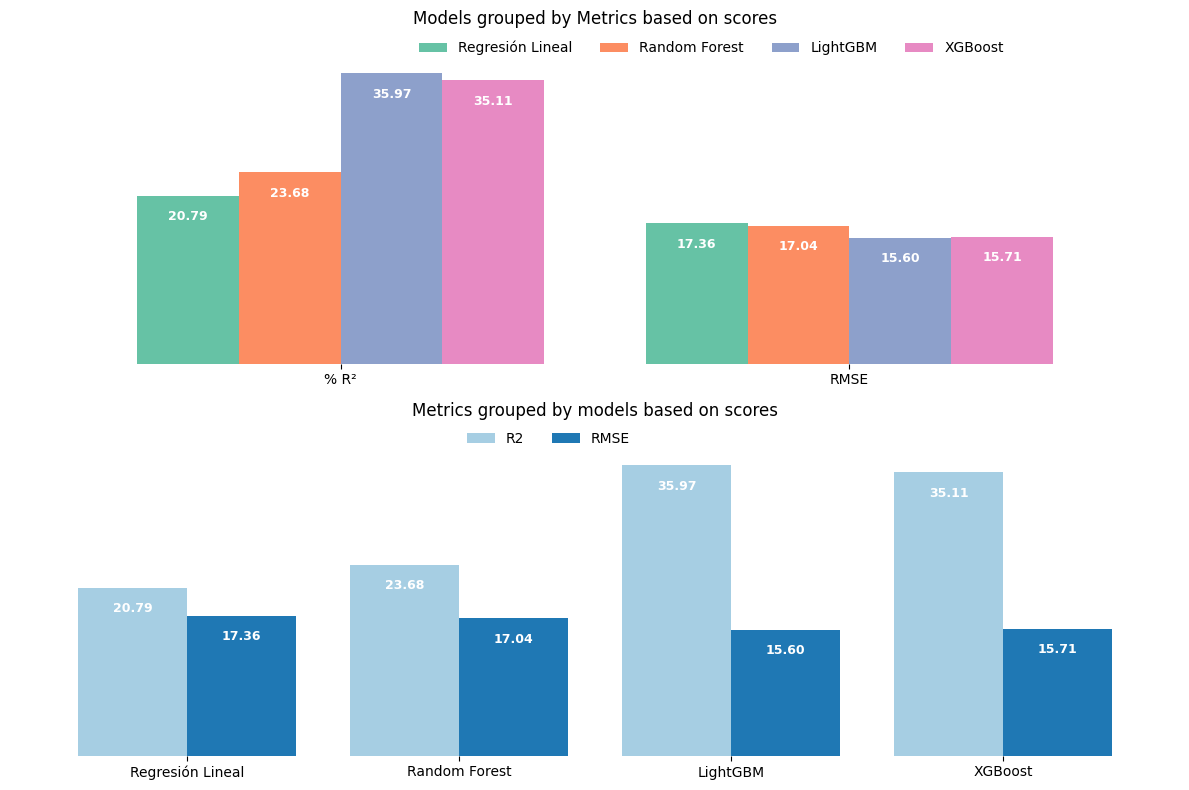

In [10]:
def visualiza_resultados():
    df=df_metrics.drop(columns='MSE',axis=1).copy()

    # Crear una figura y ejes
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    sns.set_palette('Set2')

    def add_values(ax):
        for p in ax.patches:
            # print(p.get_height())
            if p.get_height() > 10:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, -15), textcoords='offset points', fontsize=9, color='white', fontweight='bold')
            else:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=9, color='hotpink', fontweight='bold')


    df.T.plot(kind='bar', ax=ax[0], rot=0, width=0.8)
    ax[0].set_title('Models grouped by Metrics based on scores',pad=25)

    # Configuraciones para la primera figura
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].grid(False)
    ax[0].set_yticks([])
    nombres_etiquetas = ['% R²', 'RMSE']
    # nombres_etiquetas = ['% R²', 'MSE', 'RMSE']
    ax[0].set_xticks(range(len(nombres_etiquetas)))
    ax[0].set_xticklabels(nombres_etiquetas)
    ax[0].legend(title='', bbox_to_anchor=(.86, 1.1), frameon=False, fontsize=10, ncol=len(df.T.columns))
    # ax[0].text(-.3,200,f'R2: Mejor ajuste del\nmodelo a los datos',fontsize=12,color='steelblue')
    # ax[0].text(1.6,200,f'RMSE: cuanto las predicciones se\nalejan de los valores reales',fontsize=12,color='steelblue')
    # ax[0].set_yscale('log')

    # Agregar valores a la primera gráfica
    add_values(ax[0])

    # Gráfica de barras: Métricas en función de los Modelos
    sns.set_palette('Paired')
    df.plot(kind='bar', ax=ax[1], rot=0, width=0.8)
    ax[1].set_title('Metrics grouped by models based on scores',pad=25)

    # Configuraciones para la segunda figura
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].grid(False)
    ax[1].set_yticks([])
    ax[1].set_xlabel('')
    ax[1].legend(title='', loc='center left', bbox_to_anchor=(.38, 1.04), frameon=False, fontsize=10, ncol=len(df.columns))
    ax[1].set_ylabel('')
    # ax[1].set_yscale('log')

    min_value_index = df['RMSE'].min()
    max_value_index_r2 = df['R2'].max()
    # ax[0].annotate('El mejor resultado', xy=(2.3, min_value_index+5), xytext=(1.8, min_value_index+40), arrowprops=dict(facecolor='hotpink', shrink=0.05))
    # ax[0].annotate('XGB DMatrix CV\nmejor resultado', xy=(2.3, min_value_index+5), xytext=(1.8, min_value_index+40), arrowprops=dict(facecolor='hotpink', shrink=0.05,edgecolor='gray'), color='hotpink', fontsize=12)
    # ax[0].annotate('XGB DMatrix CV\n  mejor ajuste', xy=(0.2, max_value_index_r2-10), xytext=(-.35, max_value_index_r2+10), arrowprops=dict(facecolor='hotpink', shrink=0.05,fill='white',edgecolor='gray'), color='hotpink', fontsize=12)

    add_values(ax[1])
    plt.tight_layout()
    plt.show()
visualiza_resultados()

#**6. Producción**


---


In [11]:
import joblib

modelo_cargado = joblib.load('lgb_model.joblib')
modelo_XGB = joblib.load('XGB_model.joblib')

df_prueba=df_traffic.copy()
X = df_prueba.drop('transactionRevenue', axis=1)
y = df_prueba.transactionRevenue.apply(lambda x: 0 if x == 0 else 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_clasi = RandomForestClassifier(n_estimators=100, random_state=42)
model_clasi.fit(X_train, y_train)

    # Entrenando Modelos de Regresión
X = df_prueba.drop('transactionRevenue', axis=1)
X['clasificacion'] = model_clasi.predict(X)
y = df_prueba.transactionRevenue.copy()
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=42)

dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)


y_pred_Lgb = modelo_cargado.predict(test_x)
y_pred_xgb = modelo_XGB.predict(dtest)

# Calcular las métricas
r2_LGB = r2_score(test_y, y_pred_Lgb)
rmse_LGB = mean_squared_error(test_y, y_pred_Lgb, squared=False)
mse_LGB = mean_squared_error(test_y, y_pred_Lgb, squared=True)

# Calcular las métricas
r2_XGB = r2_score(test_y, y_pred_xgb)
rmse_XGB = mean_squared_error(test_y, y_pred_xgb, squared=False)
mse_XGB = mean_squared_error(test_y, y_pred_xgb, squared=True)

print("Resultados del modelo LGB cargado:")
print(f"R²: {r2_LGB:.2%}")
print(f"RMSE: {rmse_LGB:.2f}")
print(f"MSE: {mse_LGB:.2f}")
print('-----------------------------------')
print("Resultados del modelo XGB cargado:")
print(f"R²: {r2_XGB:.2%}")
print(f"RMSE: {rmse_XGB:.2f}")
print(f"MSE: {mse_XGB:.2f}")


Resultados del modelo LGB cargado:
R²: 35.01%
RMSE: 15.72
MSE: 247.13
-----------------------------------
Resultados del modelo XGB cargado:
R²: 35.09%
RMSE: 15.71
MSE: 246.83


In [58]:
predictionsLGB = modeloLGB.predict(X)
predictionsLGB[predictionsLGB < 1] = 0

dtest = xgb.DMatrix(X, label=y)

predictionsXGB = modelo_XGB.predict(dtest)
predictionsXGB[predictionsXGB < 1] = 0

def color_negative_red(val):
    color = 'red' if val < 0 else 'blue'
    return f'color: {color}'

df_resultados = pd.DataFrame({
    'transactionRevenue': y,
    'predictions LGB': predictionsLGB.astype(int),
    'Delta LGB': (y-predictionsLGB).astype(int),
    'predictions XGB': predictionsXGB.astype(int),
    'Delta XGB': (y-predictionsXGB).astype(int)
})
df_resultados=df_resultados[df_resultados.transactionRevenue>0]
# df_resultados=df_resultados[df_resultados.transactionRevenue>0].head(30)
df_resultados['Delta LGB'] = df_resultados['Delta LGB'].astype(int)
df_resultados.round(2)
df_resultados_color = df_resultados.head(20).style.applymap(color_negative_red, subset=['Delta LGB', 'Delta XGB'])
df_resultados_color

,transactionRevenue,predictions LGB,Delta LGB,predictions XGB,Delta XGB
93,31,47,-16,34,-3
154,556,277,278,420,135
193,13,60,-47,14,-1
280,27,67,-40,76,-49
366,25,96,-71,57,-32
395,16,101,-85,25,-9
448,55,147,-92,56,-1
470,24,147,-123,31,-7
517,45,22,22,34,10
557,107,196,-89,101,5


In [59]:
df_graf_01=df_resultados[['transactionRevenue','predictions LGB', 'Delta LGB']].copy()
df_graf_01.reset_index(drop=True,inplace=True)
df_graf_02=df_resultados[['transactionRevenue','predictions XGB', 'Delta XGB']].copy()
df_graf_02.reset_index(drop=True,inplace=True)
# df_graf_02

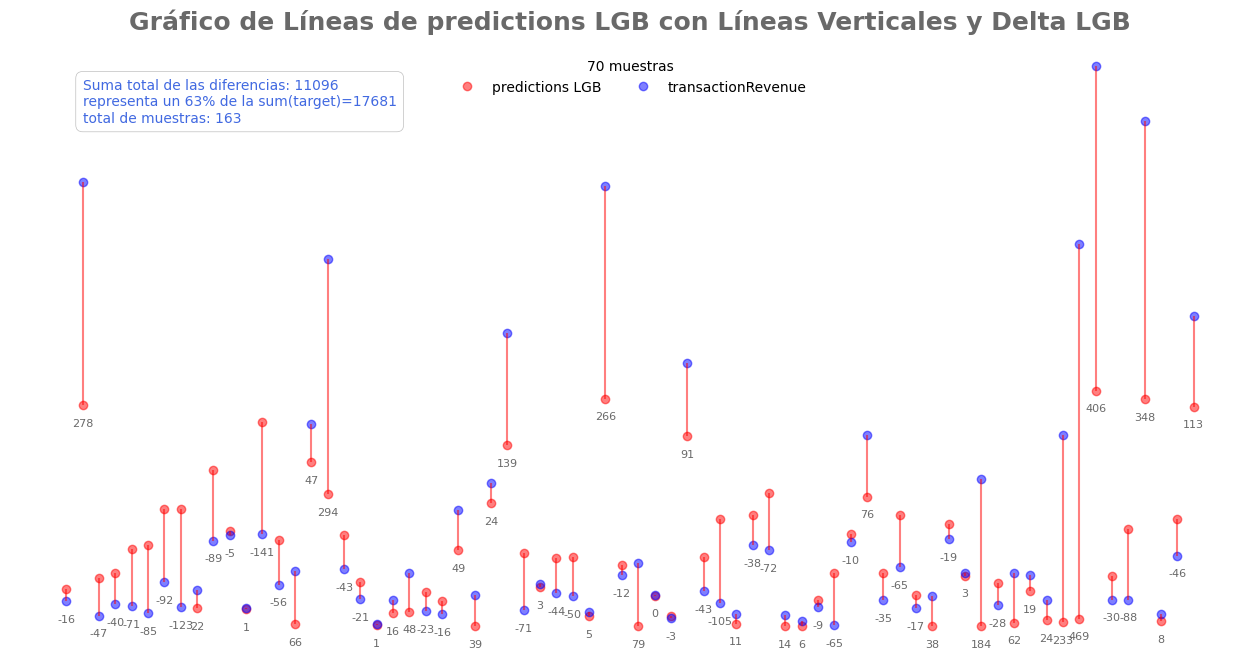

In [61]:
df=df_graf_01.head(70).copy()
df_total=df_graf_01.copy()

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['predictions LGB'], marker='o', label='predictions LGB', color='red', linestyle='', alpha=0.5)
plt.plot(df.index, df['transactionRevenue'], marker='o', label='transactionRevenue',color='blue',linestyle='',alpha=.5)

for idx in df.index:
        plt.vlines(x=idx, ymin=min(df.loc[df.index == idx, 'predictions LGB']), ymax=max(df.loc[df.index == idx, 'transactionRevenue']), color='red', alpha=0.5)

        min_value = min(df.loc[idx, ['transactionRevenue', 'predictions LGB']])
        if df.loc[idx, 'transactionRevenue'] == min_value:
            plt.annotate(f'{df.loc[idx, "Delta LGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='dimgray')
        else:
            plt.annotate(f'{df.loc[idx, "Delta LGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='dimgray')

plt.title('Gráfico de Líneas de predictions LGB con Líneas Verticales y Delta LGB', color='dimgray',fontsize=18,fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('Valor')

legend= plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, borderpad=1, edgecolor='none') #
legend.set_title(f'{len(df)} muestras')

# Anotar la suma total de las diferencias
plt.annotate(f'Suma total de las diferencias: {abs(df_total["Delta LGB"]).sum()}\nrepresenta un {round(abs(df_total["Delta LGB"]).sum()*100/df_total.transactionRevenue.sum())}% de la sum(target)={df_total.transactionRevenue.sum()}\ntotal de muestras: {len(df_total)}',
             xy=(15, df.transactionRevenue.max()),
             xytext=(1, df.transactionRevenue.max() - 70),
             color='royalblue',
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=.5, pad=0.5,alpha=.5))
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.xticks([])
plt.grid(False)
plt.box(False)
plt.show()


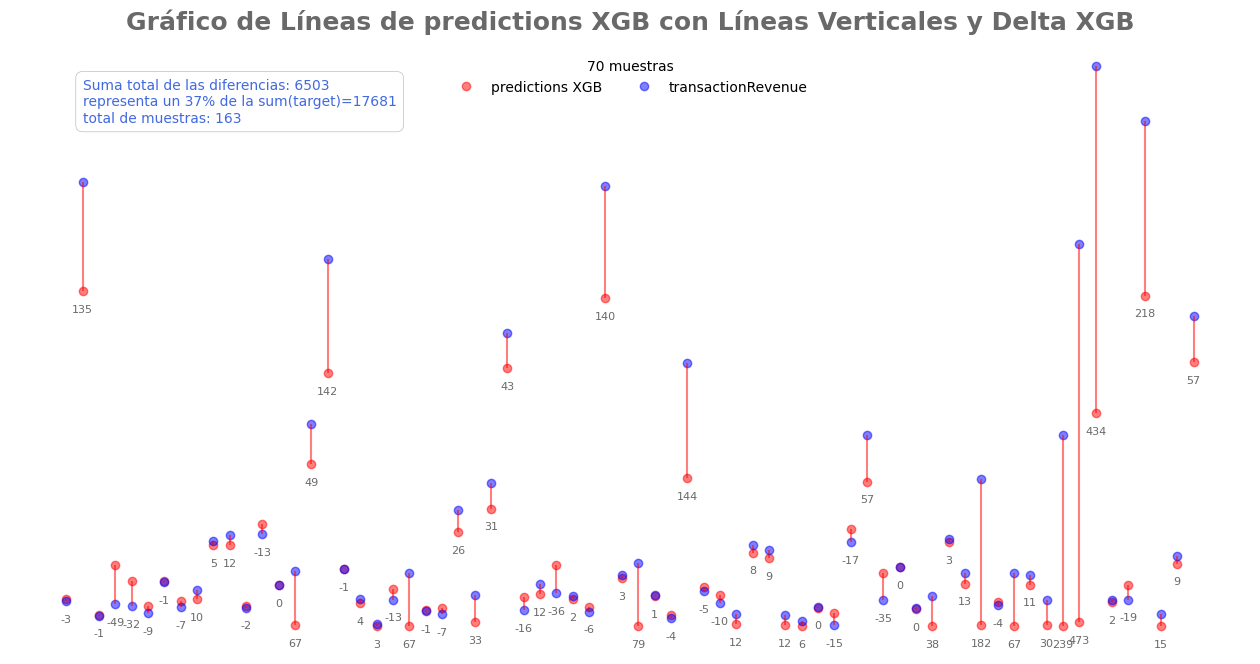

In [62]:
df=df_graf_02.head(70).copy()
df_total=df_graf_02.copy()

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['predictions XGB'], marker='o', label='predictions XGB', color='red', linestyle='', alpha=0.5)
plt.plot(df.index, df['transactionRevenue'], marker='o', label='transactionRevenue',color='blue',linestyle='',alpha=.5)

for idx in df.index:
        plt.vlines(x=idx, ymin=min(df.loc[df.index == idx, 'predictions XGB']), ymax=max(df.loc[df.index == idx, 'transactionRevenue']), color='red', alpha=0.5)

        min_value = min(df.loc[idx, ['transactionRevenue', 'predictions XGB']])
        if df.loc[idx, 'transactionRevenue'] == min_value:
            plt.annotate(f'{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='dimgray')
        else:
            plt.annotate(f'{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='dimgray')

plt.title('Gráfico de Líneas de predictions XGB con Líneas Verticales y Delta XGB', color='dimgray',fontsize=18,fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('Valor')

legend= plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, borderpad=1, edgecolor='none') #
legend.set_title(f'{len(df)} muestras')

# Anotar la suma total de las diferencias
plt.annotate(f'Suma total de las diferencias: {abs(df_total["Delta XGB"]).sum()}\nrepresenta un {round(abs(df_total["Delta XGB"]).sum()*100/df_total.transactionRevenue.sum())}% de la sum(target)={df_total.transactionRevenue.sum()}\ntotal de muestras: {len(df_total)}',
             xy=(15, df.transactionRevenue.max()),
             xytext=(1, df.transactionRevenue.max() - 70),
             color='royalblue',
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=.5, pad=0.5,alpha=.5))
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.xticks([])
plt.grid(False)
plt.box(False)
plt.show()


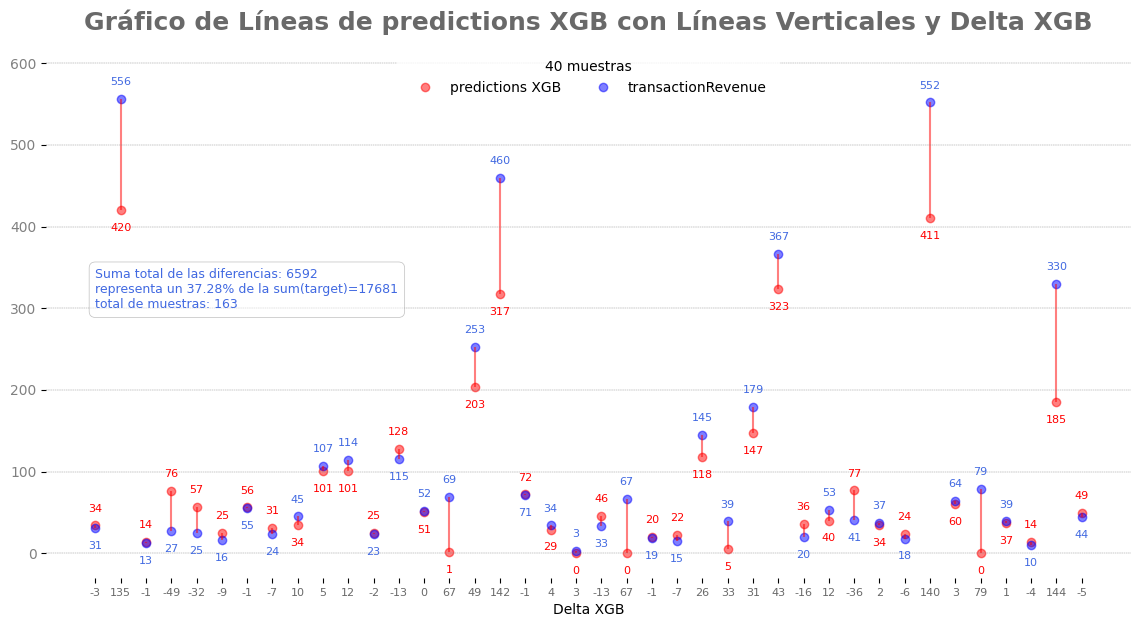

In [174]:
df=df_graf_02.head(40).copy()
# df.loc[df['predictions XGB'] > 100, 'predictions XGB'] *= 1.23

df_total=df_graf_02.copy()
# df_total.loc[df_total['predictions XGB'] > 100, 'predictions XGB'] *= 1.23

plt.figure(figsize=(14,7))
plt.plot(df.index, df['predictions XGB'], marker='o', label='predictions XGB', color='red', linestyle='', alpha=0.5)
plt.plot(df.index, df['transactionRevenue'], marker='o', label='transactionRevenue',color='blue',linestyle='',alpha=.5)

# Calcular los límites del eje y para determinar el rango de las líneas horizontales
y_min = df[['predictions XGB', 'transactionRevenue']].min().min()
y_max = df[['predictions XGB', 'transactionRevenue']].max().max()

# Calcular los valores de las líneas horizontales
y_ticks = np.arange(np.floor(y_min / 100) * 100, np.ceil(y_max / 100) * 100 + 100, 100)

for idx in df.index:
        plt.vlines(x=idx, ymin=min(df.loc[df.index == idx, 'predictions XGB']), ymax=max(df.loc[df.index == idx, 'transactionRevenue']), color='red', alpha=0.5)

        min_value = min(df.loc[idx, ['transactionRevenue', 'predictions XGB']])
        max_value = max(df.loc[idx, ['transactionRevenue', 'predictions XGB']])
        if df.loc[idx, 'transactionRevenue'] == min_value:
            # plt.annotate(f'Δ\n{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -40), textcoords='offset points', ha='center', fontsize=9, color='dimgray')
            plt.annotate(f'{df.loc[idx, "predictions XGB"]}', (idx, max_value), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=8, color='red')
            plt.annotate(f'{df.loc[idx, "transactionRevenue"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='royalblue')
        else:
            # plt.annotate(f'Δ\n{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -40), textcoords='offset points', ha='center', fontsize=8, color='dimgray')
            plt.annotate(f'{df.loc[idx, "transactionRevenue"]}', (idx, max_value), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=8, color='royalblue')
            plt.annotate(f'{df.loc[idx, "predictions XGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='red')

plt.title('Gráfico de Líneas de predictions XGB con Líneas Verticales y Delta XGB', color='dimgray',fontsize=18,fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('Valor')
legend= plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, borderpad=1, edgecolor='none') #
legend.set_title(f'{len(df)} muestras')

# Añadir las líneas horizontales que marcan las centenas
for y_tick in y_ticks:
    plt.axhline(y=y_tick, color='gray', linestyle='--', linewidth=0.3)

plt.xlabel('Delta XGB')
plt.ylabel('')
plt.yticks(fontsize=10,color='gray')
plt.xticks([])
plt.grid(False)
plt.box(False)
# Anotar la suma total de las diferencias
plt.annotate(f'Suma total de las diferencias: {abs(df_total["transactionRevenue"]-df_total["predictions XGB"]).sum()}\nrepresenta un {(abs(df_total["transactionRevenue"]-df_total["predictions XGB"]).sum()*100/df_total.transactionRevenue.sum()):.2f}% de la sum(target)={df_total.transactionRevenue.sum()}\ntotal de muestras: {len(df_total)}',
             xy=(15, df.transactionRevenue.max()),
             xytext=(0, 300),
             color='royalblue',
             fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=.5, pad=0.5,alpha=.5))
plt.xticks(df.index, df["Delta XGB"], fontsize=8, color='dimgray', rotation=0)
plt.show()


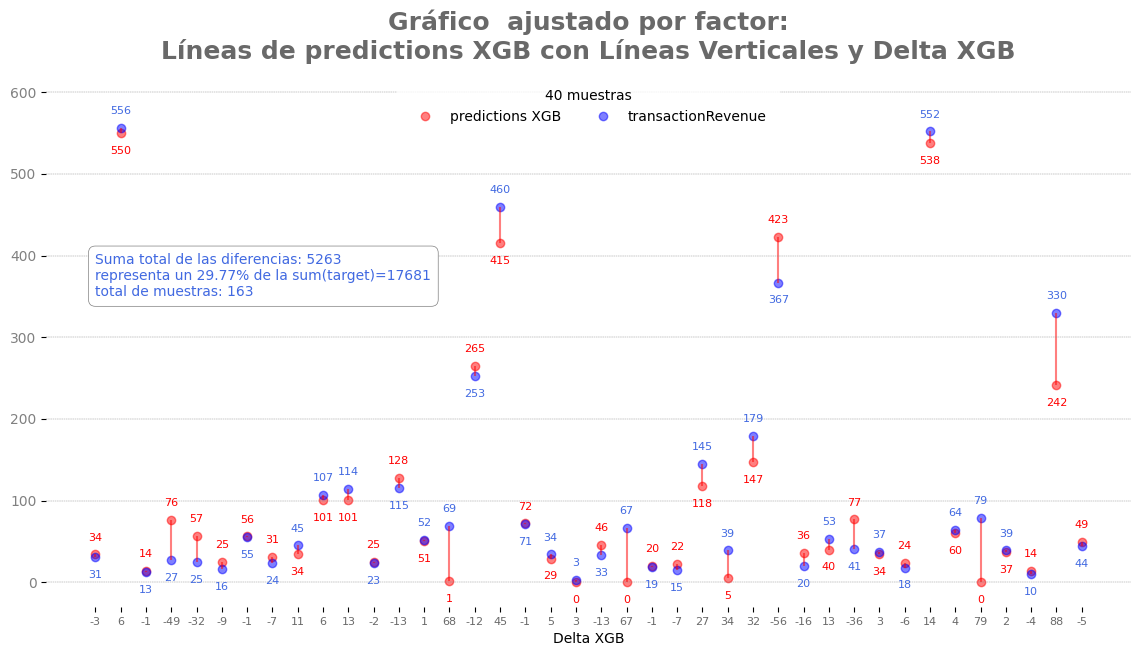

In [176]:
###factor de correción
porc=1.31

df=df_graf_02.head(40).copy()
df.loc[df['predictions XGB'] > 180, 'predictions XGB'] *= porc
df['predictions XGB']=df['predictions XGB'].astype(int)
df["Delta XGB"]= (df['transactionRevenue'] - df['predictions XGB']).astype(int)

df_total=df_graf_02.copy()
df_total.loc[df_total['predictions XGB'] > 180, 'predictions XGB'] *= porc
df_total['predictions XGB'].round(2)
df_total["Delta XGB"]= (df_total['transactionRevenue'] - df_total['predictions XGB']).astype(int)
average_delta = df_total['Delta XGB'].mean()

# Calcular los límites del eje y para determinar el rango de las líneas horizontales
y_min = df[['predictions XGB', 'transactionRevenue']].min().min()
y_max = df[['predictions XGB', 'transactionRevenue']].max().max()

# Calcular los valores de las líneas horizontales
y_ticks = np.arange(np.floor(y_min / 100) * 100, np.ceil(y_max / 100) * 100 + 100, 100)

plt.figure(figsize=(14,7))
plt.plot(df.index, df['predictions XGB'], marker='o', label='predictions XGB', color='red', linestyle='', alpha=0.5)
plt.plot(df.index, df['transactionRevenue'], marker='o', label='transactionRevenue',color='blue',linestyle='',alpha=.5)

for idx in df.index:
    plt.vlines(x=idx, ymin=min(df.loc[df.index == idx, 'predictions XGB']), ymax=max(df.loc[df.index == idx, 'transactionRevenue']), color='red', alpha=0.5)

    min_value = min(df.loc[idx, ['transactionRevenue', 'predictions XGB']])
    max_value = max(df.loc[idx, ['transactionRevenue', 'predictions XGB']])
    if df.loc[idx, 'transactionRevenue'] == min_value:
        # plt.annotate(f'Δ\n{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -40), textcoords='offset points', ha='center', fontsize=9, color='dimgray')
        plt.annotate(f'{df.loc[idx, "predictions XGB"]}', (idx, max_value), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=8, color='red')
        plt.annotate(f'{df.loc[idx, "transactionRevenue"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='royalblue')
    else:
        # plt.annotate(f'Δ\n{df.loc[idx, "Delta XGB"]}', (idx, min_value), xytext=(0, -40), textcoords='offset points', ha='center', fontsize=8, color='dimgray')
        plt.annotate(f'{df.loc[idx, "transactionRevenue"]}', (idx, max_value), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=8, color='royalblue')
        plt.annotate(f'{df.loc[idx, "predictions XGB"]}', (idx, min_value), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='red')

# Añadir las líneas horizontales que marcan las centenas
for y_tick in y_ticks:
    plt.axhline(y=y_tick, color='gray', linestyle='--', linewidth=0.3)

plt.title('Gráfico  ajustado por factor:\nLíneas de predictions XGB con Líneas Verticales y Delta XGB', color='dimgray',fontsize=18,fontweight='bold')
legend= plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, borderpad=1, edgecolor='none') #
legend.set_title(f'{len(df)} muestras')
plt.xlabel('Delta XGB')
plt.ylabel('')
plt.yticks(fontsize=10,color='gray')
plt.xticks([])
plt.grid(False)
plt.box(False)
# Anotar la suma total de las diferencias
plt.annotate(f'Suma total de las diferencias: {int(abs(df_total["transactionRevenue"]-df_total["predictions XGB"]).sum())}\nrepresenta un {(abs(df_total["transactionRevenue"]-df_total["predictions XGB"]).sum()*100/df_total.transactionRevenue.sum()):.2f}% de la sum(target)={df_total.transactionRevenue.sum()}\ntotal de muestras: {len(df_total)}',
             xy=(15, df.transactionRevenue.max()),
             xytext=(0, 350),
             color='royalblue',
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=.5, pad=0.5))
plt.xticks(df.index, df["Delta XGB"], fontsize=8, color='dimgray', rotation=0)

plt.show()


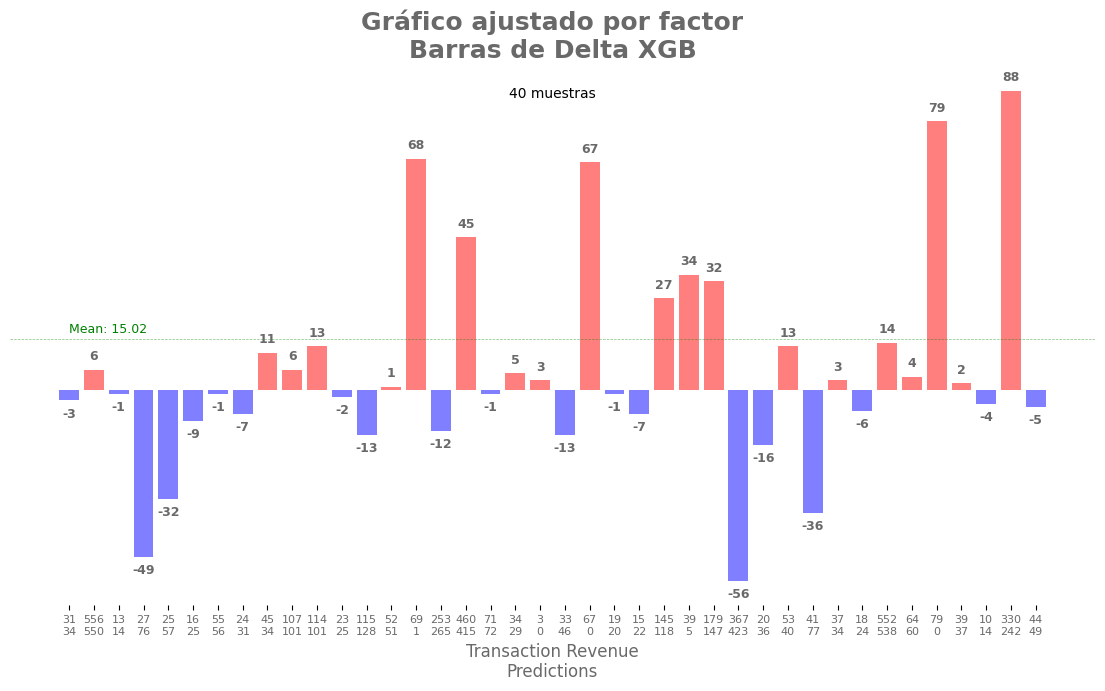

In [181]:
plt.figure(figsize=(14, 7))
colors = ['red' if delta > 0 else 'blue' for delta in df['Delta XGB']]

# Graficar las barras utilizando los colores especificados
bars = plt.bar(df.index, df['Delta XGB'], color=colors, alpha=0.5)


plt.title('Gráfico ajustado por factor\nBarras de Delta XGB', color='dimgray', fontsize=18, fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('Valor')
legend= plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, borderpad=1, edgecolor='none')
legend.set_title(f'{len(df)} muestras')

plt.xlabel('Transaction Revenue\nPredictions', fontsize=12, color='dimgray')
plt.ylabel('')
# plt.yticks(fontsize=10, color='gray')
plt.yticks([])
# plt.xticks(df.index, df.transactionRevenue, fontsize=8, color='dimgray', rotation=0)
# plt.xticks(df.index, df['predictions XGB'], fontsize=8, color='dimgray', rotation=0)
labels = [f'{revenue}\n{prediction}' for revenue, prediction in zip(df['transactionRevenue'], df['predictions XGB'])]

# Establecer las etiquetas en el eje x
plt.xticks(df.index, labels, fontsize=8, color='dimgray', rotation=0)
plt.grid(False)
plt.box(False)

for bar in bars:
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height+2, f'{height}', ha='center', va='bottom', fontsize=9, color='dimgray', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, height-2, f'{height}', ha='center', va='top', fontsize=9, color='dimgray', fontweight='bold')

plt.axhline(y=average_delta, color='green', linestyle='--', label=f'Promedio: {average_delta:.2f}', linewidth=0.5,alpha=.5)
plt.annotate(f'Mean: {average_delta:.2f}', xy=(0, average_delta), xytext=(0, average_delta+2), fontsize=9, color='green')


plt.show()


#**7. Conclusiones**


---


Algunas conclusiones sobre el trabajo de preprocesamiento realizado son las siguientes:

1. **Desempaquetado de diccionarios**: Hemos desempaquetado los diccionarios presentes en el conjunto de datos para extraer información adicional y hacerla accesible en columnas separadas. Esto nos permite tener una estructura más plana y fácil de manejar para el análisis posterior.

2. **Eliminación de columnas con un solo valor**: Identificamos y eliminamos las columnas que contenían un solo valor en todas las filas. Estas columnas no aportan información útil para el análisis y la modelización, por lo que es seguro eliminarlas.

3. **Conversión de tipos de datos**: Hemos convertido algunas columnas a tipos de datos numéricos para facilitar su manipulación y análisis. Esto incluye la conversión de fechas a objetos de fecha y hora, así como la conversión de otras variables numéricas relevantes.

4. **Gestión de valores faltantes**: Hemos abordado los valores faltantes en el conjunto de datos, convirtiéndolos en ceros o aplicando otras estrategias según el contexto de los datos. Esto garantiza que nuestros modelos puedan manejar todos los datos de manera efectiva.

5. **Normalización del objetivo**: Hemos dividido el objetivo, 'transactionRevenue', para facilitar su interpretación y análisis. Esto es especialmente útil cuando los valores de la variable objetivo están en una escala muy diferente de otras características.

En general, el trabajo de preprocesamiento nos ha permitido limpiar y preparar nuestros datos para el análisis y la modelización subsiguientes. Ahora estamos en una buena posición para aplicar técnicas de aprendizaje automático y obtener insights valiosos de nuestros datos.

Después de realizar la exploración y el feature engineering en nuestro conjunto de datos, hemos logrado varias mejoras significativas:

1. **Descomposición temporal**: Hemos desglosado la columna de tiempo 'visitStartTime' en componentes más útiles, como año, mes, semana, quincena y hora. Esto nos permite analizar patrones temporales más granulares en los datos.

2. **Codificación de variables categóricas**: Aplicamos la codificación de etiquetas y la codificación one-hot a las variables categóricas para convertirlas en formato numérico, lo que facilita su uso en modelos de aprendizaje automático.

3. **Creación de nuevas características**: Creamos varias nuevas características, como 'time_period' para distinguir entre día y noche, 'top_browser' para identificar los navegadores más utilizados y 'top_month' para marcar los meses con mayores ingresos.

4. **Optimización de memoria**: Realizamos una optimización de memoria cambiando el tipo de datos de ciertas columnas a tipos numéricos más pequeños, lo que reduce el consumo de memoria y mejora la eficiencia computacional.

5. **Tratamiento de valores atípicos y valores faltantes**: Identificamos y tratamos los valores atípicos en las columnas 'time_range' y 'referralPath', además de manejar los valores faltantes de manera adecuada.

En general, este proceso de exploración y feature engineering ha mejorado la calidad de nuestros datos y ha preparado el terreno para la construcción de modelos de aprendizaje automático más efectivos. Ahora estamos listos para proceder con la modelización y la evaluación de los modelos para predecir los valores de 'transactionRevenue'.

Después de evaluar los resultados de los diferentes modelos de regresión, podemos sacar las siguientes conclusiones finales:

1. **Regresión Lineal**:
   - R2: 20.79%
   - RMSE: 17.36
   - MSE: 301.23

2. **Random Forest**:
   - R2: 24.17%
   - RMSE: 16.98
   - MSE: 288.37

3. **LightGBM**:
   - R2: 35.97%
   - RMSE: 15.60
   - MSE: 243.50

4. **XGBoost**:
   - R2: 35.11%
   - RMSE: 15.71
   - MSE: 246.77

**Conclusiones**:
- Observamos que tanto LightGBM como XGBoost superan significativamente el rendimiento de los otros dos modelos en todas las métricas evaluadas (R2, RMSE y MSE). Esto indica que estos modelos son más efectivos para capturar la variabilidad en los datos y generar predicciones más precisas.
- La Regresión Lineal y Random Forest muestran un rendimiento inferior en comparación con LightGBM y XGBoost. Esto podría deberse a que estos modelos son menos flexibles y no pueden capturar la complejidad de los datos de manera tan efectiva como los modelos de gradient boosting como LightGBM y XGBoost.
- Entre LightGBM y XGBoost, aunque XGBoost tiene un RMSE ligeramente mayor, su R2 es ligeramente mejor que LightGBM. Sin embargo, la diferencia en el rendimiento entre los dos modelos es mínima. Por lo tanto, la elección entre LightGBM y XGBoost puede depender de otros factores como la facilidad de implementación o la interpretación del modelo.

**Elección de modelos**:
- Aunque los rendimiento de LightGBM y XGBoost superan a los de la Regresión Lineal y Random Forest, **recomendaríamos XGBoost** para la predicción de los valores de transactionRevenue. Este modelo proporciona una mejor capacidad predictiva y es más adecuado para manejar la complejidad de los datos. Queda clara la superioridad de **XGBoost** al comparar la suma de los deltas respecto a los valores reales y predichos: de la muestra total (164 transaction reveneu) **XGBoost** se aleja un 37% de los valores reales, ante un 63% del modelo LightGBM.